In [21]:
import sys
import os
from pathlib import Path

import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import torch
from torchvision.models.detection import maskrcnn_resnet50_fpn
import albumentations as A
from albumentations.pytorch import ToTensorV2
from skimage.color import gray2rgb
from torchvision.ops import nms
from pytorch_toolbelt.utils import to_numpy
from dotenv import load_dotenv
from torchvision.utils import draw_segmentation_masks


from src.visualization import tensor_to_image

current_dir = Path(".")
load_dotenv()
current_dir.absolute()

PosixPath('/home/maxim/sartorius_instance_segmentation')

In [22]:
# Global config of configuration
test_images_dir = Path(os.environ['dataset_path']) / "test"
weights_dir = current_dir / "weights" / "inference.ckpt"
device = "cpu"

# Local tunable parameters of evaluation
score_threshold = 0.0  # All predictions would be counted, even with low score
nms_threshold = 0.1  # Overlapping instances will be dropped, lower - lower overlap is permitted
mask_threshold = 0.5  # Cut masks by the threshold

In [23]:
assert test_images_dir.is_dir(), f"Check test dir path for correctness, was looking at {test_images_dir.absolute()}"
assert weights_dir.is_file(), f"File not found, was looking at {weights_dir.absolute()}"

In [24]:
preprocess_image = A.Compose([
    A.Normalize(mean=(0.485,), std=(0.229,)),
    ToTensorV2(),
])

In [25]:
model = maskrcnn_resnet50_fpn(progress=False, num_classes=4)
model.load_state_dict(torch.load(weights_dir, map_location=torch.device("cpu")))
model.to(device)
model = model.eval()

In [26]:
image_paths = list(test_images_dir.glob("**/*.png"))

In [27]:
def load_image(image_path: str):
    image = io.imread(str(image_path))
    return image

In [28]:
def get_masks_from_image(image):
    image = preprocess_image(image=image)['image']
    image = image.to(device)
    
    with torch.no_grad():
        output = model.forward([image])[0]

    scores = output['scores'].detach().cpu()
    masks = output['masks'].squeeze().detach().cpu()
    boxes = output['boxes'].detach().cpu()

    print(f"found {len(boxes)} instances!")

    masks = (masks >= mask_threshold).int()

    # Now some masks can be empty (all zeros), we need to exclude them
    indices = torch.as_tensor([torch.sum(mask) > 0 for mask in masks])
    masks, boxes, scores = masks[indices], boxes[indices], scores[indices]

    print(f"After mask thresholding survived {len(masks)} instances")

    indices = scores >= score_threshold
    masks, boxes, scores = masks[indices], boxes[indices], scores

    print(f"After confidence thresholding survived {len(masks)} instances")

    indices = nms(boxes, scores, nms_threshold)
    masks, boxes, scores = masks[indices], boxes[indices], scores[indices]

    print(f"Finally, after NMS survived {len(masks)} instances!") 
    return masks

In [29]:
def to_rgb_image(im: torch.Tensor):
    return np.transpose(im.numpy(), axes=(1, 2, 0))

def draw_segmentation_mask(image, masks):
    gt_image = gray2rgb(image.squeeze())
    gt_image = torch.as_tensor(np.transpose(gt_image, axes=(2, 0, 1)), dtype=torch.uint8)
    gt_masks = torch.as_tensor(masks == 1)

    segm = draw_segmentation_masks(
        image=gt_image,
        masks=gt_masks,
        alpha=0.5
    )
    
    fig, axes = plt.subplots(ncols=1, figsize=(10, 10))
    axes.imshow(to_rgb_image(segm))
    axes.set_xticks([])
    axes.set_yticks([])
    plt.tight_layout(pad=0.1, h_pad=0.1, w_pad=0.1)
    plt.show()
    # fig.savefig(f"../figures/{image_id}-{cell_type}.png")

found 100 instances!
After mask thresholding survived 100 instances
After confidence thresholding survived 100 instances
Finally, after NMS survived 94 instances!


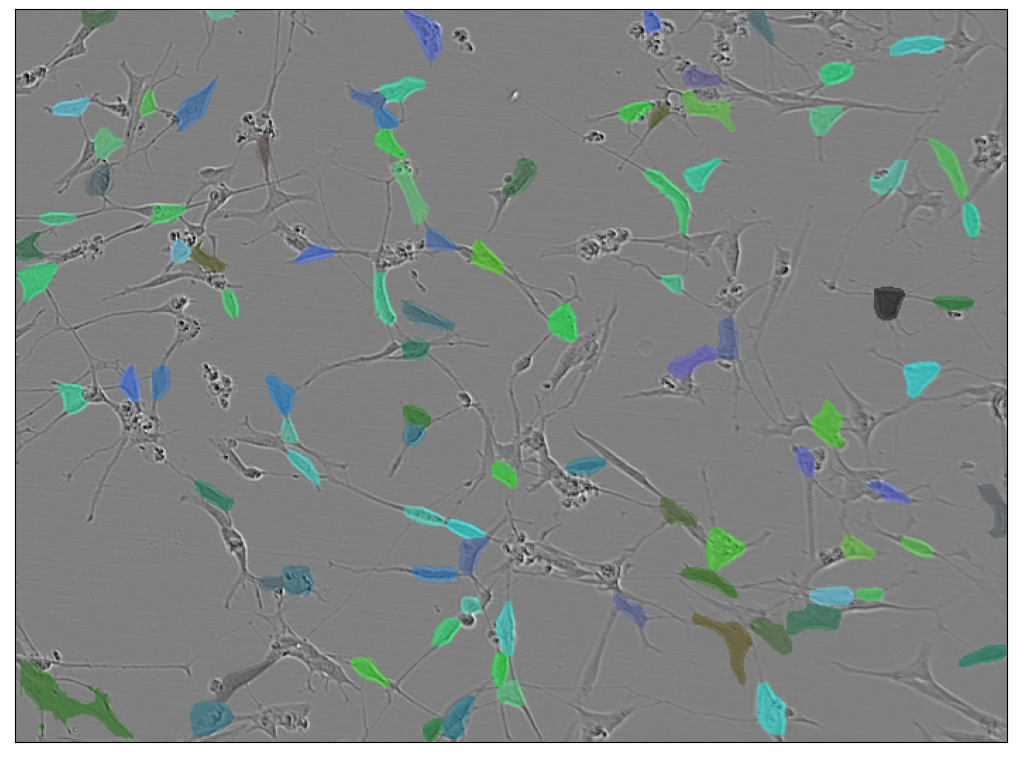

In [30]:
# def draw_masks(image_path: str):
image = load_image(image_paths[1])
masks = get_masks_from_image(image)
draw_segmentation_mask(image, masks)